# Exploration du jeu de données fourni par Elo

Le jeu de données se compose de 4 fichiers :
- un fichier "train.csv" avec la variable "target" à prédire (c'est un score de fidélité normalisé) ;
- un fichier "historical_transactions.csv" ;
- un fichier "new_merchants_transactions.csv" qui a les mêmes colonnes que le fichier "historical_transactions" ; il concerne les transactions auprès d'un nouveau marchand (les premières fois) ;
- un fichier "merchants.csv" comportant des informations sur les marchands.

Un fichier "test.csv" est également mis à disposition, avec de nouvelles card_id pour lesquelles il est demandé de calculer un score de prédiction.

Chargements des packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
# Affichage interactif avec Bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()
import scipy.special
from bokeh.models import LabelSet, ColumnDataSource
from bokeh.models.tools import HoverTool

Loading BokehJS ...

Importation des fichiers

In [2]:
df_train = pd.read_csv("train.csv")
#df_test = pd.read_csv("test.csv")
#df_m = pd.read_csv("merchants.csv")
#df_new = pd.read_csv("new_merchant_transactions.csv")

#DataFrame réduit avec nrows
#df_hist = pd.read_csv("historical_transactions.csv", nrows = 10000)

## Le fichier train.csv

### Présentation

Le fichier train se compose de 201 917 lignes, correspondant chacune à une card_id différente, et de 6 colonnes :
 - card_id : un identifiant unique
 - first_active_month : le mois du premier achat de la card_id
 - feature_1 : une feature catégorielle anonymisée, pouvant prendre les valeurs 1, 2, 3, 4 ou 5
 - feature_2 : une feature catégorielle anonymisée, pouvant prendre les valeurs 1, 2 ou 3
 - feature_3 : une feature catégorielle anonymisée, pouvant prendre les valeurs 0 ou 1
 - target : le score de fidélité à prédire

### Caractéristiques générales

On va maintenant regarder les caractéristiques de ce fichier.

- On affiche les 5 premières lignes

In [ ]:
df_train.head(5)

- Comporte-t-il des valeurs manquantes ?

In [ ]:
pd.isnull(df_train).any()

Il n'y a pas de valeurs manquantes dans ce fichier. 

- A quoi ressemblent les colonnes ?

In [ ]:
df_train.info()

In [ ]:
df_train.describe()

### La variable cible : target

- On trace un histogramme afin de voir la répartition des valeurs de la cible "target"

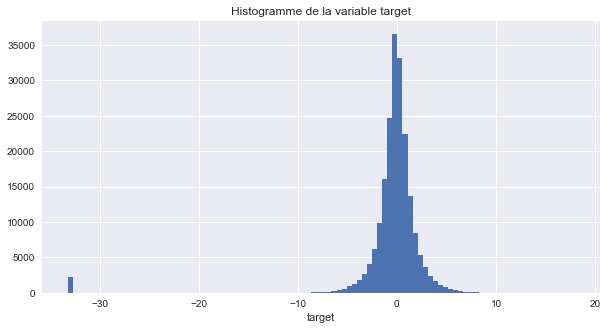

In [3]:
fig = plt.figure(figsize =(10, 5))
ax = fig.add_subplot(111)
ax.hist(df_train['target'], bins=100);
ax.set_xlabel("target");
ax.set_title("Histogramme de la variable target")
plt.show()

- Le même graphique en version interactive avec Bokeh

In [ ]:
histogram, edges = np.histogram(df_train["target"], bins = 50)

source = ColumnDataSource(data=dict(histogram = histogram, left = edges[:-1], right = edges[1:]))

p = figure(plot_width = 600, plot_height = 300, 
           title = "Distribution de la variable target dans le fichier train",
          x_axis_label = "target")
p.quad(top = "histogram", bottom = 0, left = "left", right = "right", fill_color = "green", 
      hover_fill_color = "red", source = source)
hover = HoverTool(tooltips = [("nb de card_id", "@histogram"),("target", "$x")])
p.add_tools(hover)
show(p)

- On regarde la répartition des variables catégorielles anonymisées feature_1, feature_2 et feature_3 grâce à des diagrammes en barres.

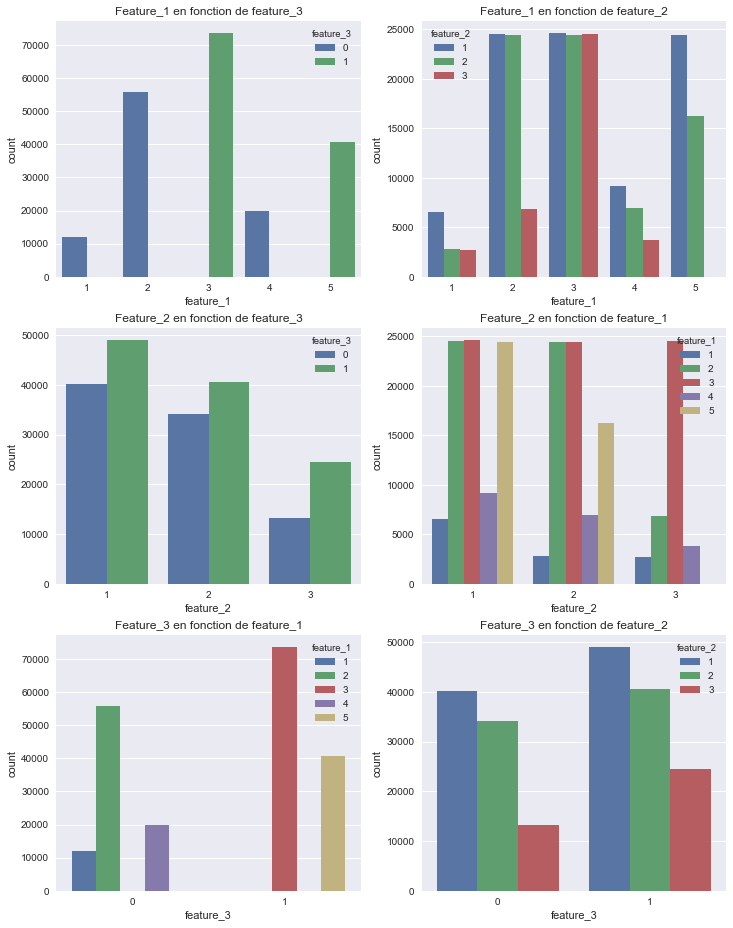

In [4]:
fig = plt.figure(figsize = (12,16))
ax1 = fig.add_subplot(321)
sns.countplot(x = "feature_1", hue = "feature_3", data = df_train, ax = ax1);
ax1.set_title("Feature_1 en fonction de feature_3");

ax2 = fig.add_subplot(322)
sns.countplot(x = "feature_1", hue = "feature_2", data = df_train, ax = ax2);
ax2.set_title("Feature_1 en fonction de feature_2");

ax3 = fig.add_subplot(323)
sns.countplot(x = "feature_2", hue = "feature_3", data = df_train, ax = ax3);
ax3.set_title("Feature_2 en fonction de feature_3");

ax4 = fig.add_subplot(324)
sns.countplot(x = "feature_2", hue = "feature_1", data = df_train, ax = ax4);
ax4.set_title("Feature_2 en fonction de feature_1");

ax5 = fig.add_subplot(325)
sns.countplot(x = "feature_3", hue = "feature_1", data = df_train, ax = ax5);
ax5.set_title("Feature_3 en fonction de feature_1");

ax6 = fig.add_subplot(326)
sns.countplot(x = "feature_3", hue = "feature_2", data = df_train, ax = ax6);
ax6.set_title("Feature_3 en fonction de feature_2");

plt.show()


On constate que les features 1 et 3 sont redondantes : si on connait la feature_1, on connait la feature_3.

### Valeurs aberrantes

On constate la présence de 2207 card_id qui ont un score de fidélité à -33. A quoi cette valeur correspond-elle ? 

In [23]:
df_train_ab = df_train[df_train["target"] < -20]
df_train_ab.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
64,2017-09,C_ID_8186f3fcc1,3,1,1,-33.219281
92,2015-05,C_ID_b9379a30ea,3,3,1,-33.219281
125,2015-10,C_ID_e9120f535c,3,3,1,-33.219281
151,2017-03,C_ID_65715cb80d,4,2,0,-33.219281
225,2017-01,C_ID_ae77d244b6,2,1,0,-33.219281


Ce ne sont pas toujours les mêmes variables, il faudra donc aller voir dans les fichiers historical et new_merchant_transactions. On récupère dans une liste les card_id aberrantes, *my_card_id_ab*

In [24]:
my_card_id_ab = list(df_train_ab["card_id"])

## Le document test


In [ ]:
df_test = pd.read_csv("test.csv")

In [ ]:
df_test.shape

## Le fichier transactions_reduced 

Il se compose des colonnes my_columns pour les card_id du fichier train, et possède les informations des fichiers historical et new_merchants

In [4]:
my_columns = ["authorized_flag", "card_id", "installments", "merchant_id", "purchase_amount", "purchase_date"]
other_columns = ["month_lag", "category_3", "category_1", "merchant_category_id", "subsector_id", "city_id", "state_id", "category_2"]

In [5]:
df_tr = pd.read_csv("transactions_reduced.csv", usecols = my_columns)
df_tr.head()

,authorized_flag,card_id,installments,merchant_id,purchase_amount,purchase_date
0,Y,C_ID_732dcdbb46,-1,M_ID_55300fd4d0,0.282408,2018-02-17 08:35:10
1,Y,C_ID_732dcdbb46,7,M_ID_c9855bf3e3,0.090174,2017-10-20 15:44:57
2,Y,C_ID_69082a8187,0,M_ID_820c7b73c8,-0.300711,2017-11-02 12:56:54
3,Y,C_ID_69082a8187,0,M_ID_0e0ffdbe2d,0.346436,2017-03-06 18:20:59
4,Y,C_ID_69082a8187,0,M_ID_022647a832,-0.629701,2017-03-06 16:16:10


### Exploration 

- Le fichier comporte-t-il des valeurs manquantes ?

In [6]:
pd.isnull(df_tr).sum()

authorized_flag         0
card_id                 0
installments            0
merchant_id        102297
purchase_amount         0
purchase_date           0
dtype: int64

Certaines valeurs de merchant_id sont manquantes.

In [7]:
df_tr.describe()

,installments,purchase_amount
count,1.924969e+07,1.924969e+07
mean,6.501107e-01,1.163292e-01
std,2.632253e+00,1.377398e+03
min,-1.000000e+00,-7.469078e-01
25%,0.000000e+00,-7.199352e-01
50%,0.000000e+00,-6.875531e-01
75%,1.000000e+00,-6.011055e-01
max,9.990000e+02,6.010604e+06


In [10]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19249694 entries, 0 to 19249693
Data columns (total 6 columns):
authorized_flag    object
card_id            object
installments       int64
merchant_id        object
purchase_amount    float64
purchase_date      object
dtypes: float64(1), int64(1), object(4)
memory usage: 881.2+ MB


- Comment se répartissent les montants dépensés ?

In [16]:
histogram, edges = np.histogram(df_tr["purchase_amount"][df_tr["purchase_amount"] < 1], bins = 100)

source = ColumnDataSource(data=dict(histogram = histogram, left = edges[:-1], right = edges[1:]))

p = figure(plot_width = 600, plot_height = 300, 
           title = "Distribution de la variable purchase_amount dans le fichier transactions",
          x_axis_label = "purchase_amount")
p.quad(top = "histogram", bottom = 0, left = "left", right = "right", fill_color = "green", 
      hover_fill_color = "red", source = source)
hover = HoverTool(tooltips = [("nb de transactions", "@histogram"),("purchase_amount", "$x")])
p.add_tools(hover)
show(p)

### Classification des clients en 6 catégories selon la méthode RFM

In [32]:
my_columns = ["card_id", "purchase_amount"]
df_red = pd.read_csv("transactions_reduced.csv", usecols = my_columns)
df_red.head()

,card_id,purchase_amount
0,C_ID_732dcdbb46,0.282408
1,C_ID_732dcdbb46,0.090174
2,C_ID_69082a8187,-0.300711
3,C_ID_69082a8187,0.346436
4,C_ID_69082a8187,-0.629701


In [33]:
liste = df_red["card_id"].value_counts()

In [40]:
liste.describe()

count    201917.000000
mean         95.334687
std         106.910822
min           2.000000
25%          31.000000
50%          60.000000
75%         118.000000
max        2915.000000
Name: card_id, dtype: float64

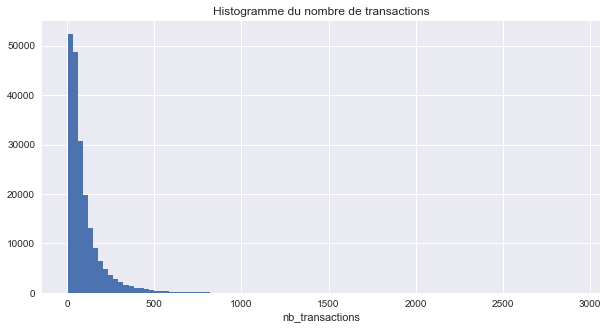

In [42]:
# Histogramme avec matplotlib
fig = plt.figure(figsize =(10, 5))
ax = fig.add_subplot(111)
ax.hist(liste, bins=100);
ax.set_xlabel("nb_transactions");
ax.set_title("Histogramme du nombre de transactions")
plt.show()

In [44]:
# Histogramme avec Bokeh
histogram, edges = np.histogram(liste, bins = 100)

source = ColumnDataSource(data=dict(histogram = histogram, left = edges[:-1], right = edges[1:]))

p = figure(plot_width = 600, plot_height = 300, 
           title = "Distribution du nombre de transactions",
          x_axis_label = "nb de transactions")
p.quad(top = "histogram", bottom = 0, left = "left", right = "right", fill_color = "green", 
      hover_fill_color = "red", source = source)
hover = HoverTool(tooltips = [("nb de clients", "@histogram"),("nb de transactions", "$x")])
p.add_tools(hover)
show(p)

In [47]:
# Histogramme avec Bokeh
histogram, edges = np.histogram(liste[liste < 500], bins = 100)

source = ColumnDataSource(data=dict(histogram = histogram, left = edges[:-1], right = edges[1:]))

p = figure(plot_width = 600, plot_height = 300, 
           title = "Distribution du nombre de transactions",
          x_axis_label = "nb de transactions")
p.quad(top = "histogram", bottom = 0, left = "left", right = "right", fill_color = "green", 
      hover_fill_color = "red", source = source)
hover = HoverTool(tooltips = [("nb de clients", "@histogram"),("nb de transactions", "$x")])
p.add_tools(hover)
show(p)

### Données aberrantes

In [25]:
df_tr_ab = df_tr[df_tr["card_id"].isin(my_card_id_ab)]

In [26]:
df_tr_ab.head()

,authorized_flag,card_id,purchase_amount
10102,Y,C_ID_cfdb2cdc49,-0.736585
10103,N,C_ID_cfdb2cdc49,-0.711520
10104,Y,C_ID_cfdb2cdc49,-0.656749
10105,N,C_ID_cfdb2cdc49,-0.707088
10106,Y,C_ID_cfdb2cdc49,-0.716855


In [28]:
df_tr_ab["authorized_flag"].value_counts()

Y    159441
N     28125
Name: authorized_flag, dtype: int64

In [30]:
df_tr_ab.describe()

,purchase_amount
count,187566.000000
mean,0.126445
std,206.246693
min,-0.746893
25%,-0.721363
50%,-0.688304
75%,-0.596793
max,87140.705912
